In [1]:
!which python; python --version; pwd

/Users/swagatam/miniconda3/envs/sbi/bin/python
Python 3.10.14
/Users/swagatam/Desktop/ws24/sbi/sourcerer-sequential/results_analysis


In [35]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [3]:
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.family'] = "sans-serif"
# matplotlib.rcParams['legend.fontsize'] = 15
# matplotlib.rcParams['axes.labelsize'] = 15
# matplotlib.rcParams['xtick.labelsize'] = 15
# matplotlib.rcParams['ytick.labelsize'] = 15
# matplotlib.rcParams['legend.title_fontsize'] = 15
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
# matplotlib.rcParams['figure.dpi'] = 250
# matplotlib.rcParams['figure.figsize'] = (4,3)
# cmap = plt.get_cmap("viridis")

this notebook has baseline and data aggregation results:
- with fixed lambda, no aggregation of training data over iterations
- if keeping data from previous iterations helps (aggregate data)

In [4]:
# base_path_baseline = '../results_sequential_naive_baseline/'
# base_path_aggregate = '../results_sequential_naive_aggrdata/'
foldertxt = "seq_{S}_{B}_{I}_{SEED}"
filetxt = 'run_{B}_{I}_{SEED}_results_df.csv'

In [5]:
base_path_aggregate = '../results_sequential_hh_more_iters/'
foldertxt = 'seq_{S}_{B}_{I}_{SEED}'
filetxt = 'run_{B}_{I}_{SEED}_results_df.csv'

In [47]:
SIMULATORS = ["gaussian_mixture", "inverse_kinematics", "two_moons", "slcp", "hh"]
SEEDS = {
    "gaussian_mixture": [34358, 12235, 9656, 3828, 54973],
    "inverse_kinematics": [34358, 12235, 9656, 3828, 54973],
    "two_moons": [50134, 12235, 9656, 3828, 54973],
    "slcp": [20367, 12235, 9656, 3828, 54973],
    "hh": [12235, 54973, 34358, 3828, 9656],
}
METRICS_NAMES = ['surro_c2sts',
                 'source_simu_pf_c2sts',
                 'source_surro_pf_c2sts',
                 # "source_simu_pf_swds",
                 'source_entropies'
                ]
METRICS_LABELS = {
    "surro_c2sts": "Surrogate C2ST",
    # "source_simu_pf_swds": "Source  SWD (PF using sim.)",
    "source_simu_pf_c2sts": "Source C2ST (PF using NNS)",
    "source_surro_pf_c2sts": "Source C2ST (PF using surr.)",
    "source_entropies": "Source entropy estimate",
}

In [7]:
np.genfromtxt('../results_sequential_naive_aggrdata/seq_slcp_12000_10_20367/run_12000_10_20367_expected_swd.csv')

array(0.17703132)

In [8]:
# mean_gt_swd(base_path_baseline, 'slcp', 1000, 4)

In [9]:
def path_to_csv(base_path, sim, budget, iters, seed):
    return os.path.join(base_path,
                        foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                        filetxt.format(B=budget, I=iters, SEED=seed)
                       )
def average_df_over_seeds(base_path, sim, budget, iters):
    dflist = []
    columns = pd.read_csv(path_to_csv(base_path, sim, budget, iters, SEEDS[sim][0])).columns # just fetch column names
    for seed in SEEDS[sim]:
        path = path_to_csv(base_path, sim, budget, iters, seed)
        if os.path.exists(path):
            dflist.append(
                pd.read_csv(path)
            )
        else:
            print(f"Could not find file: {path}")
    # assert len(dflist) == len(SEEDS[sim])
    mean_df = pd.DataFrame(np.stack(dflist, axis=0).mean(0), columns=columns)
    std_df = pd.DataFrame(np.stack(dflist, axis=0).std(0), columns=columns)
    return mean_df, std_df

def gt_source_kole(base_path, sim, budget, iters, seed):
    path_to_array = os.path.join(base_path,
                                 foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                 f"run_{budget}_{iters}_{seed}_gt_source_kole.csv"
                                )
    # print(path_to_array)
    return np.genfromtxt(path_to_array)

def mean_gt_source_kole(base_path, sim, budget, iters):
    arrays = []
    for seed in SEEDS[sim]:
        arrays.append(
            gt_source_kole(base_path, sim, budget, iters, seed)
        )
    # print(arrays)
    return np.array(arrays).mean()

def gt_swd(base_path, sim, budget, iters, seed):
    # print(sim, budget, iters, seed)
    path_to_array = os.path.join(base_path,
                                 foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                 f"run_{budget}_{iters}_{seed}_expected_swd.csv"
                                )
    # print(path_to_array)
    return np.genfromtxt(path_to_array)


def mean_gt_swd(base_path, sim, budget, iters):
    arrays = []
    for seed in SEEDS[sim]:
        arrays.append(
            gt_swd(base_path, sim, budget, iters, seed)
        )
    # print(arrays)
    return np.array(arrays).mean()


def fetch_losses(base_path, sim, budget, iters, seed):
    train_losses_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_train_losses_surro.csv"
                                    )
    val_losses_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_val_losses_surro.csv"
                                    )
    train_losses_source_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_source_training_losses.csv"
                                    )
    train_losses = np.genfromtxt(train_losses_path)
    val_losses = np.genfromtxt(val_losses_path)
    train_losses_source = np.genfromtxt(train_losses_source_path)
    
    return train_losses, val_losses, train_losses_source


def loss_plots(base_path, sim, budget, iters, seed, start_idx=100):
    train, val, src_train = fetch_losses(base_path, sim, budget, iters, seed)

    title = f"{sim}\nb={budget}, its={iters}"
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
    
    axes[0].plot(train[start_idx:], label=f"surro. train loss")
    axes[0].plot(val[start_idx:], label=f"surro. val. loss")
    axes[0].set_xlabel("epochs")
    axes[0].legend(fontsize=6, title=title, title_fontsize=7)
    axes[1].plot(src_train, label=f"source training loss"); 
    axes[1].set_xlabel("epochs")
    # axes[1].set_yscale('log')
    axes[1].legend(fontsize=6, title=title, title_fontsize=7)
    
    return fig

In [10]:
simulator = "hh"
b=50_000
it=5
seed = SEEDS[simulator][0]
seed

12235

In [11]:
pd.read_csv(path_to_csv(base_path_aggregate, simulator, b, it, SEEDS[simulator][4]))

,budgets,surro_c2sts,surro_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_entropies
0,10000,0.84655,0.157659,0.60615,0.65410,8.705589
1,10000,0.80885,0.134593,0.59490,0.63675,8.887484
2,10000,0.81075,0.123173,0.59115,0.62120,8.826946
3,10000,0.78490,0.107768,0.58195,0.60710,9.018970
4,10000,0.79105,0.102459,0.58180,0.61190,9.027954


In [12]:
pd.read_csv(path_to_csv(base_path_aggregate, simulator, b, 3, SEEDS[simulator][3]))

,budgets,surro_c2sts,surro_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_entropies
0,16666,0.8400,0.121576,0.6022,0.64400,8.701594
1,16666,0.7936,0.108974,0.5761,0.61110,8.842370
2,16666,0.7892,0.105219,0.5857,0.62215,8.652538


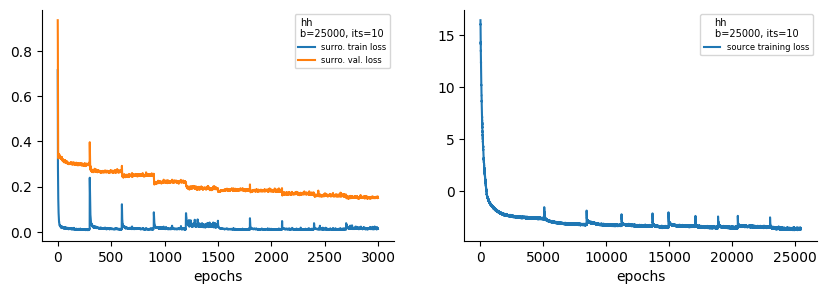

In [13]:
loss_plots(base_path_aggregate, simulator, 25_000, 10, SEEDS[simulator][2], start_idx=0)
plt.show()

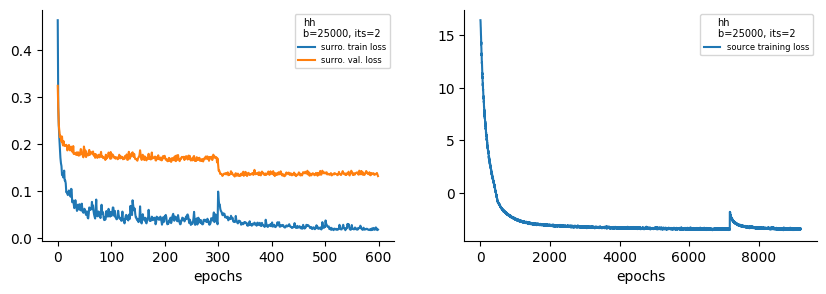

In [14]:
loss_plots(base_path_aggregate, simulator, 25000, 2, SEEDS[simulator][2], start_idx=0)
plt.show()

In [15]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[0]

,budgets,surro_c2sts,surro_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_entropies
0,10000.0,0.84563,0.164263,0.60319,0.65756,8.585705
1,10000.0,0.81731,0.134817,0.59067,0.62956,8.731657
2,10000.0,0.81791,0.119615,0.58791,0.62420,8.812473
3,10000.0,0.79348,0.110457,0.58246,0.61772,8.929568
4,10000.0,0.79412,0.102824,0.58705,0.61447,8.940047


In [16]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[0]

,budgets,surro_c2sts,surro_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_entropies
0,10000.0,0.84563,0.164263,0.60319,0.65756,8.585705
1,10000.0,0.81731,0.134817,0.59067,0.62956,8.731657
2,10000.0,0.81791,0.119615,0.58791,0.62420,8.812473
3,10000.0,0.79348,0.110457,0.58246,0.61772,8.929568
4,10000.0,0.79412,0.102824,0.58705,0.61447,8.940047


In [17]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[1]

,budgets,surro_c2sts,surro_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_entropies
0,0.0,0.004058,0.004126,0.002975,0.004262,0.067567
1,0.0,0.004874,0.005189,0.003847,0.004890,0.093734
2,0.0,0.009888,0.006594,0.002418,0.006095,0.052769
3,0.0,0.008747,0.002523,0.004104,0.008666,0.049289
4,0.0,0.002375,0.003445,0.007486,0.006641,0.067864


In [18]:
# BUDGETS = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 12_000, 15_000]
# ITERS = [1, 2, 3, 4, 5, 6, 8, 10]

BUDGETS = [10_000, 25_000, 50_000, 100_000, 250_000, 500_000]
ITERS = [10, 8, 6, 5, 4, 3, 2, 1]

In [19]:
def plot_metrics(simulator, base_path):
    rows, nrows = BUDGETS, len(BUDGETS)
    ncols = len(METRICS_NAMES)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

    gt_ent, gt_wasser = None, None
    for loci, b in enumerate(rows):
        gt_entropy = mean_gt_source_kole(base_path, simulator, b, 1)
        gt_wasser = mean_gt_swd(base_path, simulator, b, 1)
        
        vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
        stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
        for i, num_iters in enumerate(ITERS):
            mean_df, std_df = average_df_over_seeds(base_path, simulator, b, num_iters)
            mean_df = mean_df[METRICS_NAMES].iloc[-1:]
            std_df = std_df[METRICS_NAMES].iloc[-1:]
            vals[i], stds[i] = mean_df.values, std_df.values

        for locj in range(ncols):
            ax = axes[loci, locj]
            ax.errorbar(x=ITERS, y=vals[:, locj], yerr=stds[:, locj], capsize=1.5, elinewidth=2, fmt='o', linestyle='-')#, label="Direct DT")
            # ax.plot(iters, vals[:, locj], 'o-')
            if locj!=ncols-1:
                ax.set_ylim(0.45, 0.9)
                ax.axhline(0.5, color='g', ls=':')
            else:
                ax.axhline(gt_entropy, color='k', ls=':', label='gt kole')
                # ax.axhline(gt_swds, color='r', ls=':', label='gt swd')
                ax.legend()

            ax.set_title(f"{simulator}, B: {b}")
            ax.set_xlabel("# iterations")
            ax.set_ylabel(METRICS_NAMES[locj])

    return fig

Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv


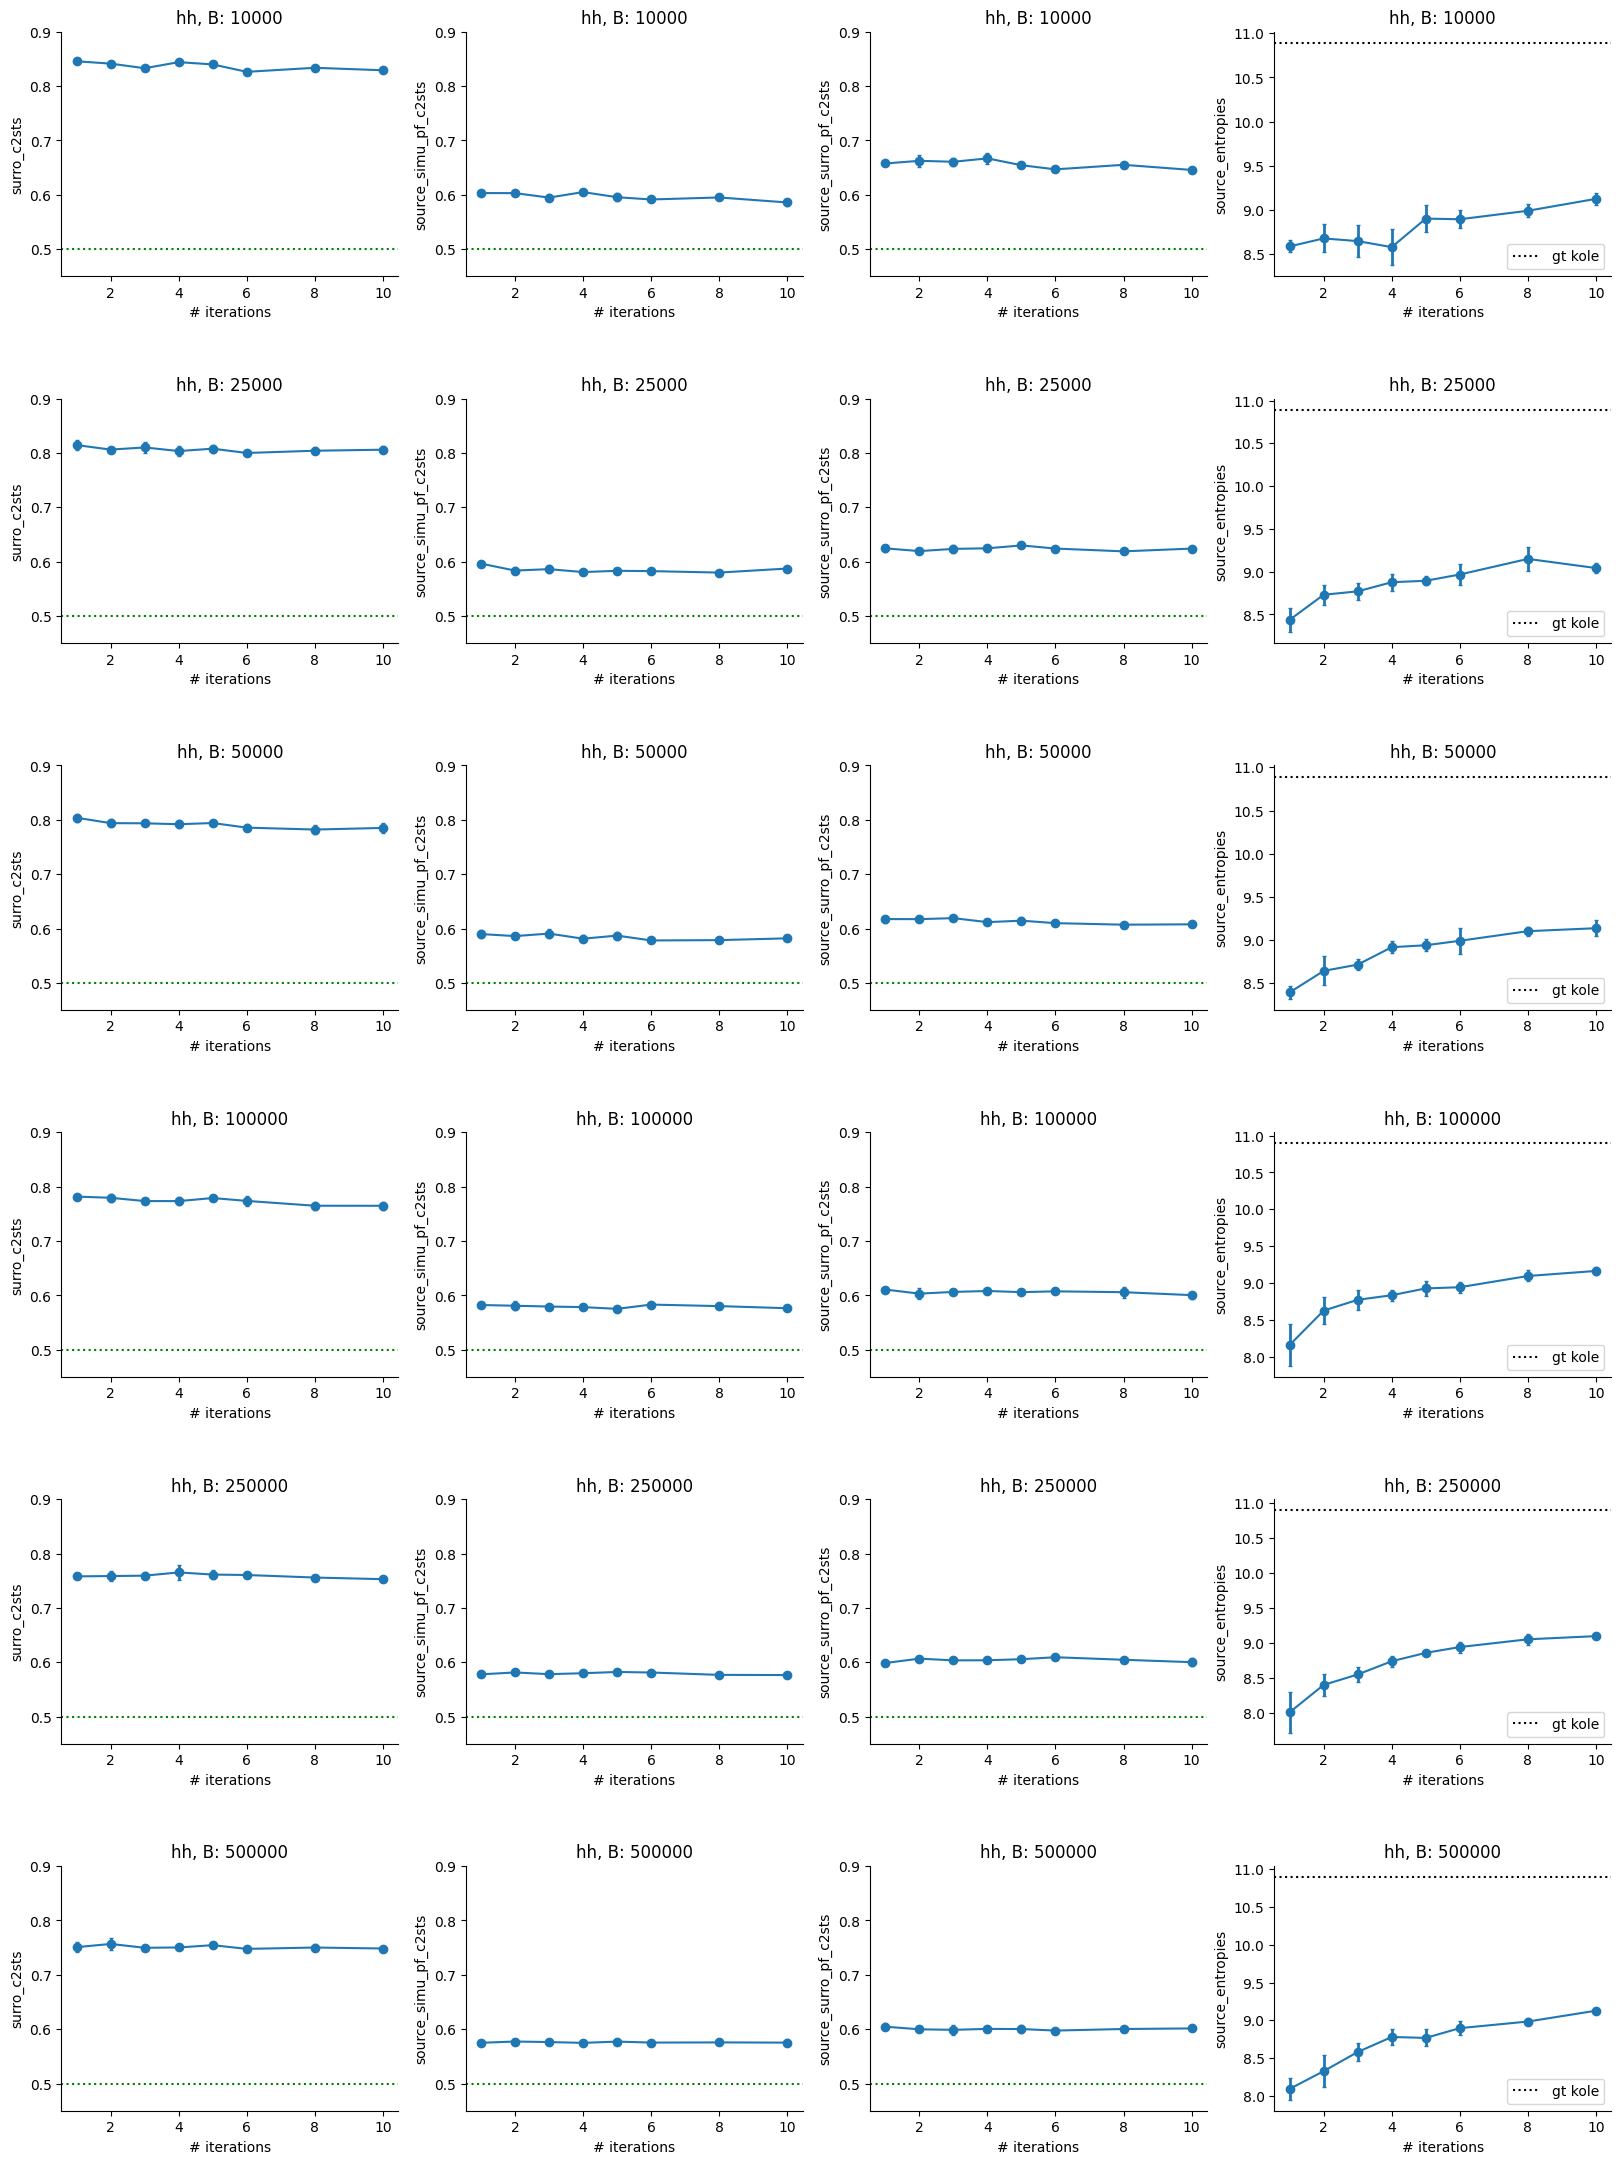

In [20]:
plot_metrics(simulator='hh', base_path=base_path_aggregate)
plt.show()

In [21]:
# plot_metrics(simulator='slcp', base_path=base_path_baseline)
# plt.show()

In [22]:
METRICS_NAMES

['surro_c2sts',
 'source_simu_pf_c2sts',
 'source_surro_pf_c2sts',
 'source_entropies']

Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv


/var/folders/qp/4w02sqhj6_d43815lhzjb7900000gn/T/ipykernel_10651/165261663.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


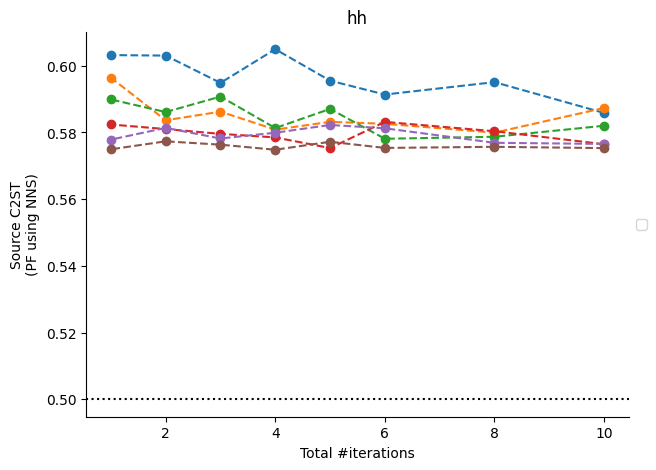

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

simulator='hh'
metric_idx = 1

plt_baselines = []
plt_aggregates = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for bidx, b in enumerate(BUDGETS):
    # vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    # stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    # for i, num_iters in enumerate(ITERS):
    #     mean_df, std_df = average_df_over_seeds(base_path_baseline,
    #                                             simulator, b, num_iters)
    #     mean_df = mean_df[METRICS_NAMES].iloc[-1:]
    #     std_df = std_df[METRICS_NAMES].iloc[-1:]
    #     vals[i], stds[i] = mean_df.values, std_df.values

    
    # # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
    #             # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    # p1, = ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b}")
    # plt_baselines.append(p1)
    
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p2, = ax.plot(ITERS, vals[:, metric_idx], 'o--',color=colors[bidx])
    plt_aggregates.append(p2)



# leg1 = plt.legend(plt_baselines[0:1], ['no data aggr.'], loc='upper right', bbox_to_anchor=(1.24, 0.92))
# leg2 = plt.legend(plt_aggregates[0:1], ["data aggr."], loc='upper right', bbox_to_anchor=(1.244, 0.8))
# ax.add_artist(leg1); 
# ax.add_artist(leg2)


# ax.set_ylim(0.45, 0.8)
ax.axhline(0.5, color='k', ls=':')

ax.set_title(f"{simulator}")
ax.set_xlabel("Total #iterations")
ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    

# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
# mean_gt_source_kole(base_path_aggregate, simulator, 1000000, 2)

In [25]:
METRICS_LABELS, METRICS_NAMES

({'surro_c2sts': 'Surrogate C2ST',
  'source_simu_pf_c2sts': 'Source C2ST\n(PF using NNS)',
  'source_surro_pf_c2sts': 'Source C2ST\n(PF using surr.)',
  'source_entropies': 'Source entropy estimate'},
 ['surro_c2sts',
  'source_simu_pf_c2sts',
  'source_surro_pf_c2sts',
  'source_entropies'])

FileNotFoundError: [Errno 2] No such file or directory: '../results_sequential_hh_more_iters/seq_hh_1000000_10_12235/run_1000000_10_12235_results_df.csv'

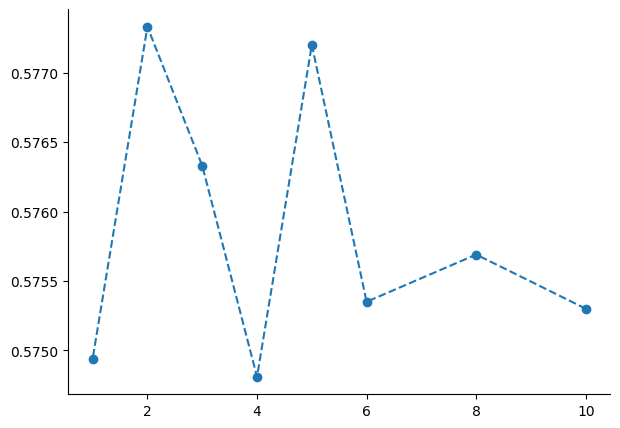

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))

simulator='hh'
metric_idx = 1

plt_baselines = []
plt_aggregates = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for bidx, b in enumerate([500_000, 1_000_000]):
    # vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    # stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    # for i, num_iters in enumerate(ITERS):
    #     mean_df, std_df = average_df_over_seeds(base_path_baseline,
    #                                             simulator, b, num_iters)
    #     mean_df = mean_df[METRICS_NAMES].iloc[-1:]
    #     std_df = std_df[METRICS_NAMES].iloc[-1:]
    #     vals[i], stds[i] = mean_df.values, std_df.values

    
    # # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
    #             # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    # p1, = ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b}")
    # plt_baselines.append(p1)
    
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p2, = ax.plot(ITERS, vals[:, metric_idx], 'o--',color=colors[bidx])
    plt_aggregates.append(p2)



# leg1 = plt.legend(plt_baselines[0:1], ['no data aggr.'], loc='upper right', bbox_to_anchor=(1.24, 0.92))
# leg2 = plt.legend(plt_aggregates[0:1], ["data aggr."], loc='upper right', bbox_to_anchor=(1.244, 0.8))
# ax.add_artist(leg1);
# ax.add_artist(leg2)


ax.set_ylim(0.45, 0.8)
ax.axhline(0.5, color='k', ls=':')

ax.set_title(f"{simulator}")
ax.set_xlabel("Total #iterations")
ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
def plot_metric_multiple_budgets(base_path, simulator, metric_idx,
                                 budgets=BUDGETS,
                                 error_bars=False,
                                 legend=True,
                                 ax=None
                                ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for bidx, b in enumerate(budgets):
        vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
        stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
        for i, num_iters in enumerate(ITERS):
            mean_df, std_df = average_df_over_seeds(base_path, simulator, b, num_iters)
            mean_df, std_df = mean_df[METRICS_NAMES].iloc[-1:], std_df[METRICS_NAMES].iloc[-1:]
            vals[i], stds[i] = mean_df.values, std_df.values
        if error_bars:
            ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx], capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b:,}")
        else:
            ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b:,}")

    # if METRICS_NAMES[metric_idx] in ['surro_c2sts', 'source_simu_pf_c2sts', 'source_surro_pf_c2sts']:
    #     ax.axhline(0.5, color='k', ls=':')
    #     ax.set_ylim(0.45, 0.85)
    # if METRICS_NAMES[metric_idx] == 'source_simu_pf_swds':
    #     ax.axhline(mean_gt_swd(base_path, simulator, 1_000_000, 1), color='k', ls='--', label='baseline swd') # any budget/iter work here
    #     handles, _ = ax.get_legend_handles_labels()
    #     # Slice list to remove budgets
    #     ax.legend(handles = handles[-1:])
    # if METRICS_NAMES[metric_idx] == 'source_entropies':
    #     ax.axhline(mean_gt_source_kole(base_path, simulator, 1_000_000, 1), color='r', ls='--', label='gt kole') # any budget/iter work here
    
    ax.set_title(f"simulator: {simulator}")
    ax.set_xlabel("Total #iterations")
    ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # return ax

In [28]:
METRICS_NAMES

['surro_c2sts',
 'source_simu_pf_c2sts',
 'source_surro_pf_c2sts',
 'source_entropies']

Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv
Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv


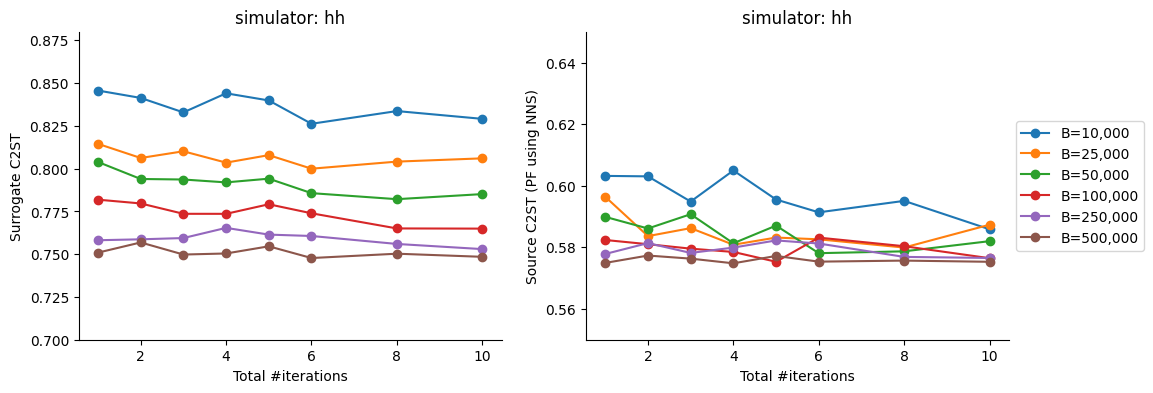

In [60]:
simulator='hh'
error_bars = False
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True, error_bars=error_bars)
axes[0].set_ylim(0.70, 0.88)
axes[1].set_ylim(0.55, 0.65)
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=2, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[1], legend=True)

plt.show()

Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv
Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv


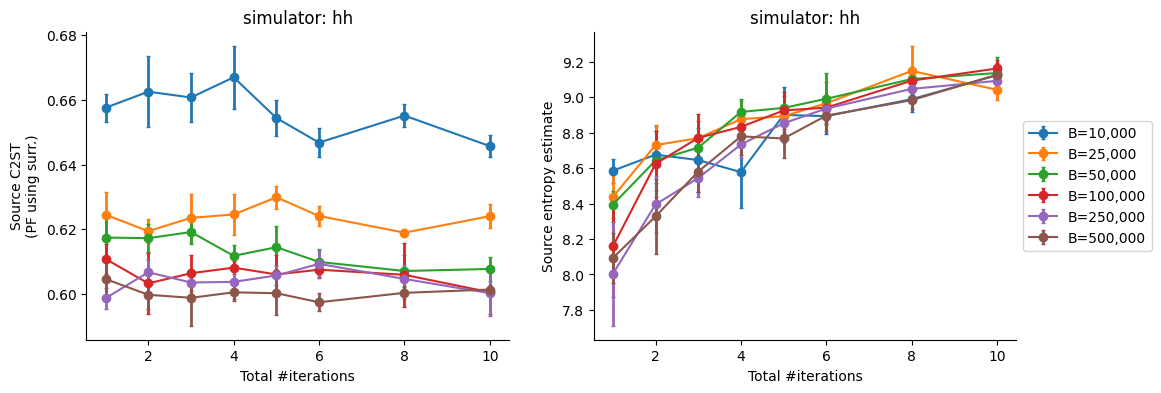

In [30]:
simulator='hh'
error_bars = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=2, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[1], legend=True, error_bars=error_bars)
# axes[0].set_ylim(0.70, 0.88)
# axes[1].set_ylim(0.55, 0.65)
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=2, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[1], legend=True)

plt.show()

In [31]:
# simulator='inverse_kinematics'
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

# plt.show()

In [32]:
# simulator='two_moons'
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)
# axes[0].set_ylim(0.45, 0.6); axes[1].set_ylim(0.45, 0.6)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

# plt.show()

In [55]:
# simulator='gaussian_mixture'
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)
# # axes[0].set_ylim(0.45, 0.7); axes[1].set_ylim(0.45, 0.7)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

# plt.show()

from matplotlib.ticker import FuncFormatter

def format_ticks(value, _):
    if value >= 1_000_000:  # Millions
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:  # Thousands
        return f'{value / 1_000:.0f}k'
    else:  # Smaller numbers
        return f'{value:.0f}'

In [34]:
ALL_BUDGETS = BUDGETS # yaxis
ALL_ITERS = ITERS # xaxis
ALL_METRICS_MEANS = {}
ALL_METRICS_STDS = {}
simulator = 'hh'


for bidx, b in enumerate(ALL_BUDGETS):
    ALL_METRICS_MEANS[b] = {}
    ALL_METRICS_STDS[b] = {}
    for i, num_iters in enumerate(ALL_ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate, simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        ALL_METRICS_MEANS[b][num_iters] = mean_df
        ALL_METRICS_STDS[b][num_iters] = std_df

Could not find file: ../results_sequential_hh_more_iters/seq_hh_250000_6_54973/run_250000_6_54973_results_df.csv


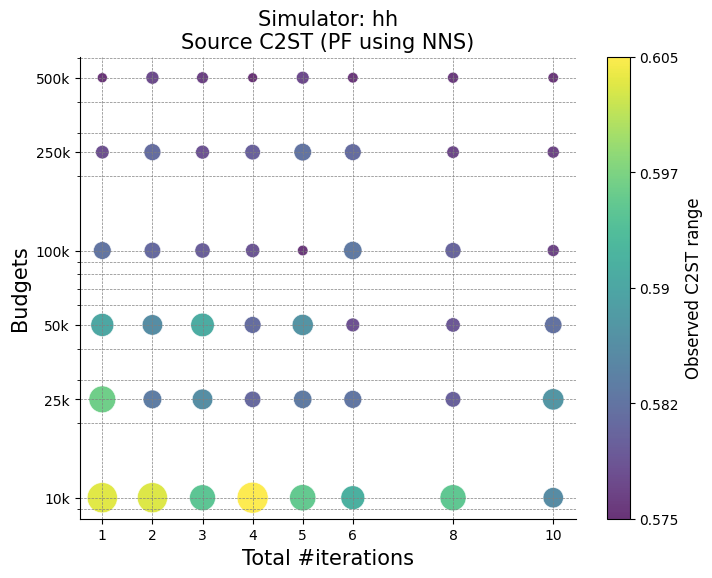

In [58]:
# Your dataset
x = np.array(ALL_ITERS)
y = np.array(ALL_BUDGETS)

# Create coordinate grids
x_coords = np.repeat(x.reshape(1, -1), len(y), 0).flatten()
y_coords = np.repeat(y, len(x))

metric_idx=1
metric_name = METRICS_NAMES[metric_idx]
# get the values at each coordinate
values_flat = []
for xc, yc in zip(x_coords, y_coords):
    values_flat.append(
        ALL_METRICS_MEANS[yc][xc][metric_name].item()
    )
values_flat = np.array(values_flat)

# Step 1: Normalize sizes
scaler = MinMaxScaler(feature_range=(50, 500))  # Bubble sizes in pixels
sizes = scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 2: Normalize colors
color_scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize for colormap
colors = color_scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 3: Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x_coords, y_coords,
    s=sizes,  # Use normalized sizes
    c=colors,  # Use normalized colors
    cmap='viridis',  # Colormap for gradient
    alpha=0.8,  # Slight transparency for better visual layering
    edgecolors='w',  # White edges for clarity
    linewidth=0.5
)


# Step 4: Customize gridlines
plt.xticks(x)  # Set ticks for x-axis at specific x values
plt.yticks(y)  # Set ticks for y-axis at specific y values
plt.grid(visible=True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

# Add a colorbar for reference
# plt.colorbar(scatter, label='Normalized Value')
# Step 4: Adjust the colorbar to reflect original values
cbar = plt.colorbar(scatter, label='Observed C2ST range')
cbar.set_label('Observed C2ST range', fontsize=12)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])  # Adjust ticks for normalized colors
cbar.set_ticklabels(np.linspace(values_flat.min(), values_flat.max(), 5).round(3))  # Map to original range

# Label the axes
ax.set_yscale('log')
original_ticks = y
ax.set_yticks(original_ticks)  # Add the original y-values
# ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Use scalar format (no scientific notation)
ax.get_yaxis().set_major_formatter(FuncFormatter(format_ticks))


plt.xlabel("Total #iterations", fontsize=15)
plt.ylabel("Budgets", fontsize=15)
plt.title(f"Simulator: {simulator}\n{METRICS_LABELS[metric_name]}", fontsize=15)

# Display the plot
# plt.show()
plt.savefig(f"./figures/{simulator}_bubble_chart_{METRICS_NAMES[metric_idx]}.pdf")

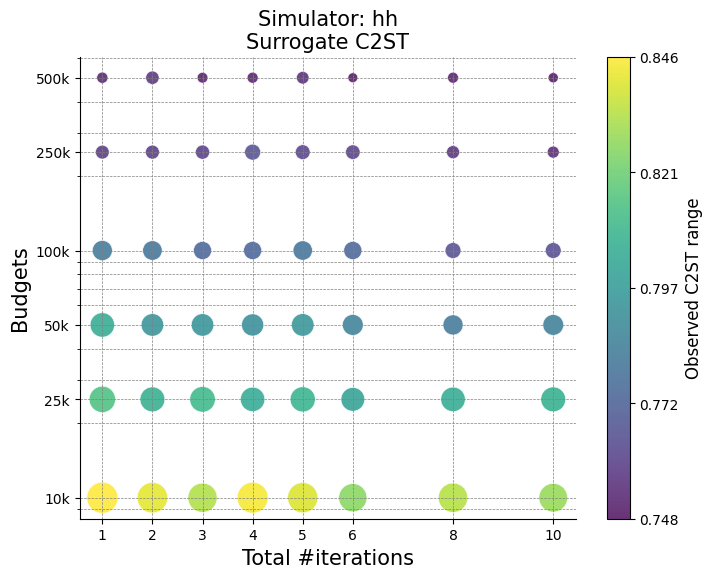

In [59]:
# Your dataset
x = np.array(ALL_ITERS)
y = np.array(ALL_BUDGETS)

# Create coordinate grids
x_coords = np.repeat(x.reshape(1, -1), len(y), 0).flatten()
y_coords = np.repeat(y, len(x))

metric_idx=0
metric_name = METRICS_NAMES[metric_idx]
# get the values at each coordinate
values_flat = []
for xc, yc in zip(x_coords, y_coords):
    values_flat.append(
        ALL_METRICS_MEANS[yc][xc][metric_name].item()
    )
values_flat = np.array(values_flat)

# Step 1: Normalize sizes
scaler = MinMaxScaler(feature_range=(50, 500))  # Bubble sizes in pixels
sizes = scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 2: Normalize colors
color_scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize for colormap
colors = color_scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 3: Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x_coords, y_coords,
    s=sizes,  # Use normalized sizes
    c=colors,  # Use normalized colors
    cmap='viridis',  # Colormap for gradient
    alpha=0.8,  # Slight transparency for better visual layering
    edgecolors='w',  # White edges for clarity
    linewidth=0.5
)


# Step 4: Customize gridlines
plt.xticks(x)  # Set ticks for x-axis at specific x values
plt.yticks(y)  # Set ticks for y-axis at specific y values
plt.grid(visible=True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

# Add a colorbar for reference
# plt.colorbar(scatter, label='Normalized Value')
# Step 4: Adjust the colorbar to reflect original values
cbar = plt.colorbar(scatter, label='Observed C2ST range')
cbar.set_label('Observed C2ST range', fontsize=12)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])  # Adjust ticks for normalized colors
cbar.set_ticklabels(np.linspace(values_flat.min(), values_flat.max(), 5).round(3))  # Map to original range

# Label the axes
ax.set_yscale('log')
original_ticks = y
ax.set_yticks(original_ticks)  # Add the original y-values
# ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Use scalar format (no scientific notation)
ax.get_yaxis().set_major_formatter(FuncFormatter(format_ticks))


plt.xlabel("Total #iterations", fontsize=15)
plt.ylabel("Budgets", fontsize=15)
plt.title(f"Simulator: {simulator}\n{METRICS_LABELS[metric_name]}", fontsize=15)

# Display the plot
# plt.show()
plt.savefig(f"./figures/{simulator}_bubble_chart_{METRICS_NAMES[metric_idx]}.pdf")